# Generative Adversarial Network
- Data: MNIST

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

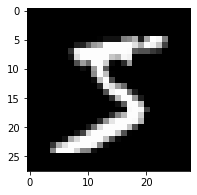

In [2]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [3]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * (feature_range[1] - feature_range[0]) + feature_range[0]
    return x

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # For label, add embedding layer
        self.label_embedding = nn.Embedding(10, 10)
        
        # define all layers
        self.fc1 = nn.Linear(input_size+10, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x, labels):       
        # flatten image
        x = x.view(-1, 28*28)
        
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.1)
        x = self.dropout(x)
        x = self.fc4(x)

        return x

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # For label, add embedding layer
        self.label_embedding = nn.Embedding(10, 10)
        
        # define all layers
        self.fc1 = nn.Linear(input_size + 10, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)        

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.1)
        x = self.dropout(x)
        x = self.fc4(x)        
        # final layer should have tanh applied
        x = F.tanh(x)
        
        return x

In [5]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 256

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of *first* hidden layer in the generator
g_hidden_size = 256

In [6]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (fc1): Linear(in_features=794, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (label_embedding): Embedding(10, 10)
  (fc1): Linear(in_features=110, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [7]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size)*0.9 if smooth else torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [8]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [9]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


In [11]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
sample_labels = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_l = torch.randint(0, 10, (sample_size,))

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, real_labels) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = scale(real_images)  # rescale input images from [0,1) to [-1, 1)
        if train_on_gpu:
            real_images = real_images.cuda()
            real_labels = real_labels.cuda()
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
                
        # 1. Train with real images
        real_out = D(real_images, real_labels)
        real_losses = real_loss(real_out, True)

        # Compute the discriminator losses on real images
        # use smoothed labels
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_labels = torch.randint(0, 10, (batch_size,))
        
        if train_on_gpu:
            z = z.cuda()
            fake_labels = fake_labels.cuda()
            
        fake_images = G(z, fake_labels)
        
        # Compute the discriminator losses on fake images        
        fake_out = D(fake_images, fake_labels)
        fake_losses = fake_loss(fake_out)
        
        # add up real and fake losses and perform backprop
        d_loss = real_losses + fake_losses
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        # Fake labels
        fake_labels = torch.randint(0, 10, (batch_size,))
        
        if train_on_gpu:
            z = z.cuda()
            fake_labels = fake_labels.cuda()
            
        fake_images = G(z, fake_labels)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        g_out = D(fake_images, fake_labels)
        
        # perform backprop
        g_loss = real_loss(g_out)
        g_loss.backward()
        g_optimizer.step()        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        fixed_l = fixed_l.cuda()
        
    samples_z = G(fixed_z, fixed_l)
    samples.append(samples_z)
    sample_labels.append(fixed_l)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples_cgan.pkl', 'wb') as f:
    pkl.dump(samples, f)
    
with open('train_samples_cgan_label.pkl', 'wb') as f:
    pkl.dump(sample_labels, f)    

Epoch [    1/  100] | d_loss: 1.2925 | g_loss: 0.6888
Epoch [    1/  100] | d_loss: 1.2886 | g_loss: 3.3738
Epoch [    1/  100] | d_loss: 0.8436 | g_loss: 2.5974
Epoch [    2/  100] | d_loss: 0.9593 | g_loss: 1.5350
Epoch [    2/  100] | d_loss: 0.5360 | g_loss: 5.3984
Epoch [    2/  100] | d_loss: 0.5808 | g_loss: 7.0913
Epoch [    3/  100] | d_loss: 0.5073 | g_loss: 6.3815
Epoch [    3/  100] | d_loss: 0.5114 | g_loss: 4.5815
Epoch [    3/  100] | d_loss: 0.5540 | g_loss: 6.2289
Epoch [    4/  100] | d_loss: 0.6610 | g_loss: 2.7499
Epoch [    4/  100] | d_loss: 0.4795 | g_loss: 6.5161
Epoch [    4/  100] | d_loss: 0.7663 | g_loss: 5.1032
Epoch [    5/  100] | d_loss: 0.6679 | g_loss: 4.0902
Epoch [    5/  100] | d_loss: 0.6058 | g_loss: 2.9214
Epoch [    5/  100] | d_loss: 0.5287 | g_loss: 6.3028
Epoch [    6/  100] | d_loss: 0.8468 | g_loss: 4.8517
Epoch [    6/  100] | d_loss: 0.5699 | g_loss: 3.4918
Epoch [    6/  100] | d_loss: 0.6470 | g_loss: 3.3117
Epoch [    7/  100] | d_loss

In [33]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, sample_labels):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for idx, (ax, img) in enumerate(zip(axes.flatten(), samples[epoch])):
        img = img.detach()
        if train_on_gpu:
            img = img.cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(sample_labels[epoch][idx].item())
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [34]:
# Load samples from generator, taken while training
with open('train_samples_cgan.pkl', 'rb') as f:
    samples = pkl.load(f)
    
with open('train_samples_cgan_label.pkl', 'rb') as f:
    sample_labels = pkl.load(f)    

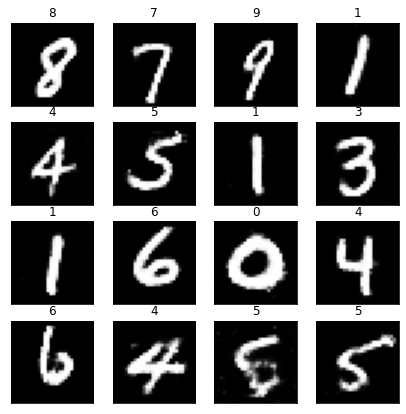

In [35]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples, sample_labels)